# Laboratorio 1
## Gasolina Gasolina regular
### Data Science
### Series de timpo
Javier Ovalle, 
José Ángel Morales, 
Ricardo Morales

Link del repositorio: https://github.com/Saiyan-Javi/Lab2DS

Importamos todas las librerías a utilizar, tanto para la parte del lab 1 como para el lab 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras


#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)
print('\n Parsed Data:')
imp['Gasolina regular'].head()

train_size = int(len(imp) * 0.7)
val_size = int(len(imp) * 0.15)

train_imp = imp[0:train_size]
val_imp = imp[train_size:train_size + val_size]
test_imp = imp[train_size + val_size:len(imp)]


 Parsed Data:


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_42632\1489584913.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)


In [19]:
ts_imp_D = train_imp['Gasolina regular']
ts_imp_D.tail(10)

Fecha
2017-04-01    681303.11
2017-05-01    386088.18
2017-06-01    519389.66
2017-07-01    433026.08
2017-08-01    592103.31
2017-09-01    316435.22
2017-10-01    574073.61
2017-11-01    434963.36
2017-12-01    679441.47
2018-01-01    571858.06
Name: Gasolina regular, dtype: float64

### Modelo Arima


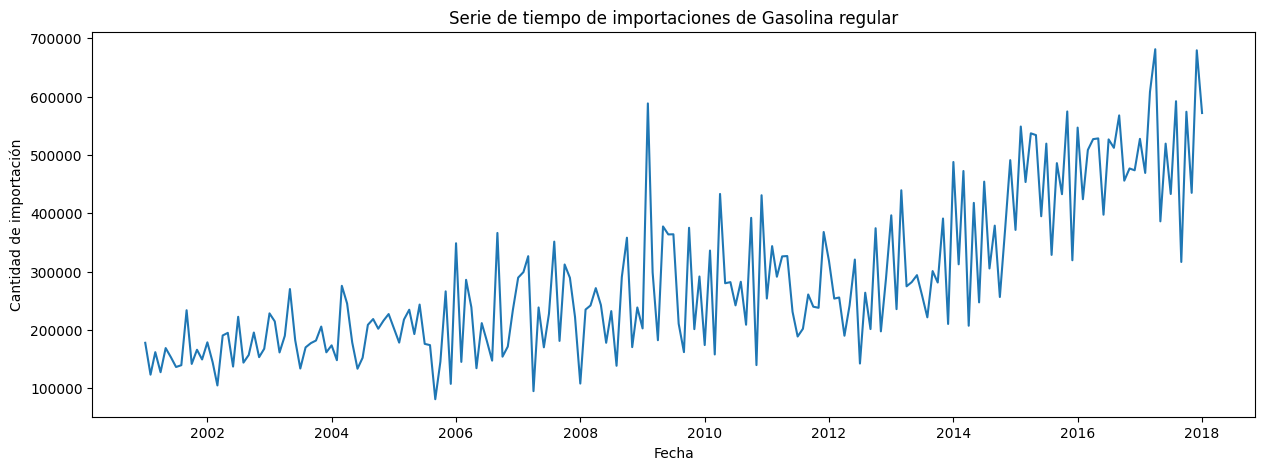

In [20]:
plt.plot(ts_imp_D)
plt.gca().set(title="Serie de tiempo de importaciones de Gasolina regular", xlabel="Fecha", ylabel="Cantidad de importación")
plt.show()

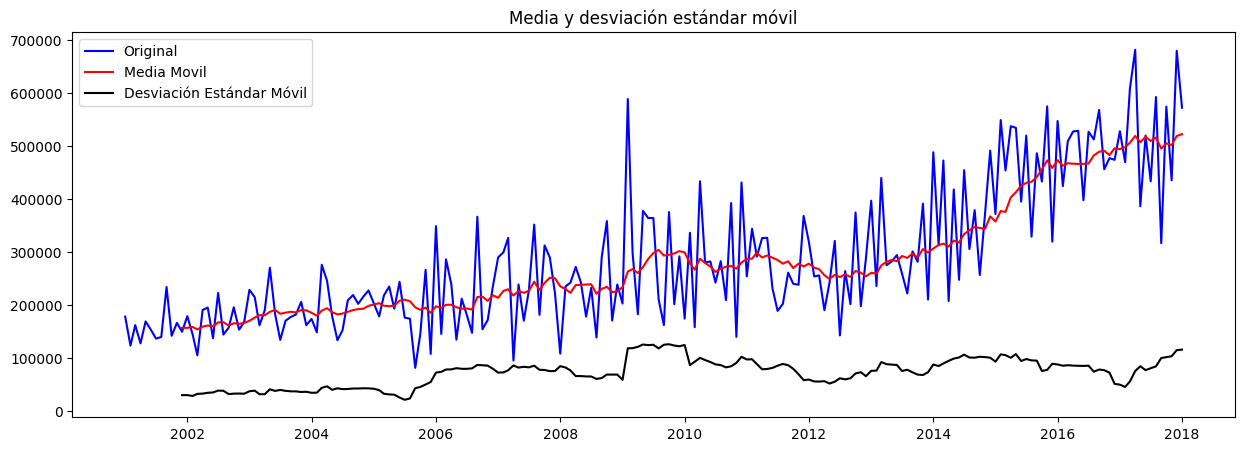

In [21]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = ts_imp_D.rolling(window=12).mean()
deMovil = ts_imp_D.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_D, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Media móvil (rojo): Muestra claramente la tendencia creciente de las importaciones.

Desviación estándar móvil (negro): Indica que la variabilidad también aumenta con el tiempo, lo que es típico en series no estacionarias.

Serie original (azul): Se aprecian fluctuaciones y picos, pero la tendencia general es al alza.

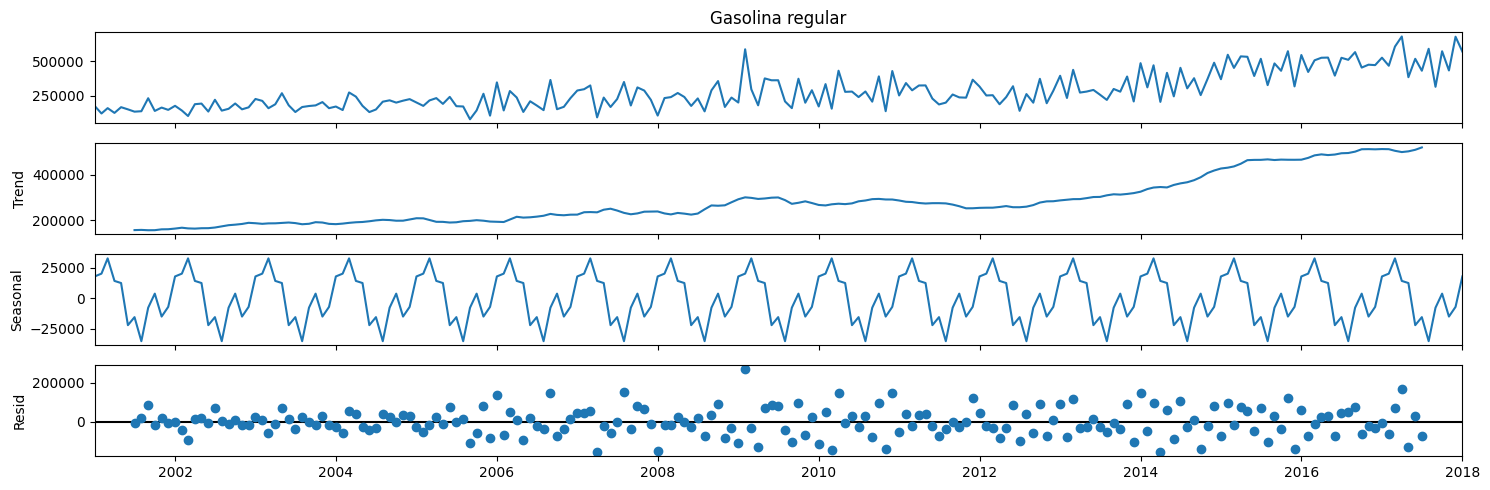

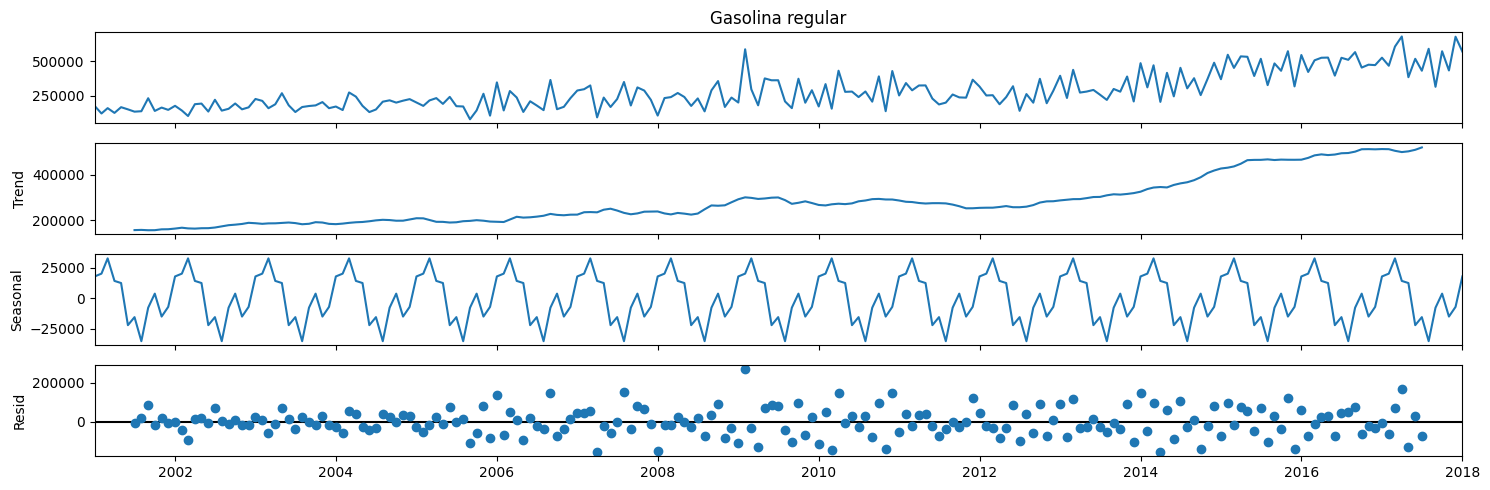

In [22]:
descomposicion = seasonal_decompose(ts_imp_D)
descomposicion.plot()

Tendencia: Se observa un crecimiento sostenido a lo largo de los años.

Estacionalidad: Hay un patrón estacional anual muy claro, con oscilaciones regulares cada año.

Residuales: Los residuos parecen estar centrados en cero, aunque con cierta variabilidad, lo que indica que la descomposición captura bien la tendencia y la estacionalidad.

## Estimar parámetros

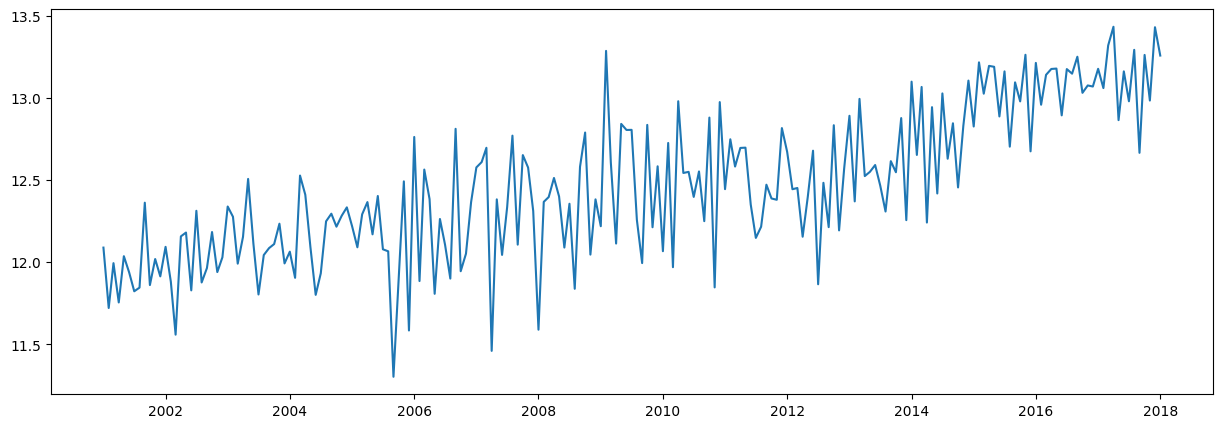

In [23]:
ts_imp_D_log = np.log(ts_imp_D)
plt.plot(ts_imp_D_log)

In [24]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_D, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.675619
p-value                        0.989339
# de retardos usados          10.000000
# de observaciones usadas    194.000000
Critical Value (1%)           -3.464515
Critical Value (5%)           -2.876556
Critical Value (10%)          -2.574775
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [25]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = ts_imp_D.diff()
ts_imp_D_diff.dropna(inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -8.157684e+00
p-value                      9.324059e-13
# de retardos usados         9.000000e+00
# de observaciones usadas    1.940000e+02
Critical Value (1%)         -3.464515e+00
Critical Value (5%)         -2.876556e+00
Critical Value (10%)        -2.574775e+00
dtype: float64


El valor P es menor a 0.05, por lo que se puede rechazar la hipótesis nula y se puede decir que no hay raices unitarias.

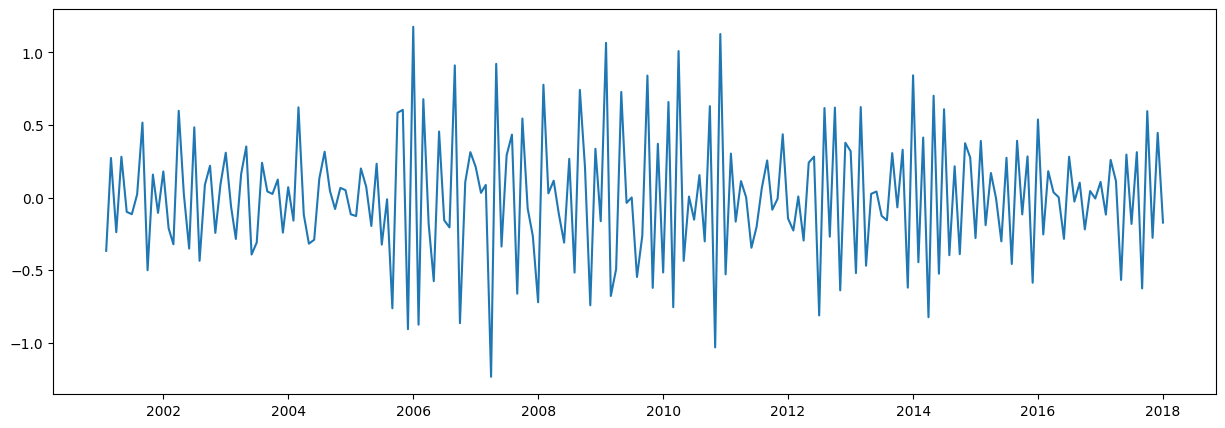

In [26]:
plt.plot(ts_imp_D_log.diff())

Podemos decir que la serie es estacionaria ahora en media y en varianza. Toca ahora estimar los parámetros del modelo.

### Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [12]:
ts_imp_D_log_diff = ts_imp_D_log.diff()
ts_imp_D_log_diff.dropna(inplace = True)
tsa_acf = acf(ts_imp_D_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_imp_D_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.69163276,  0.19619803,  0.06449973, -0.1465308 ,
        0.14521396])

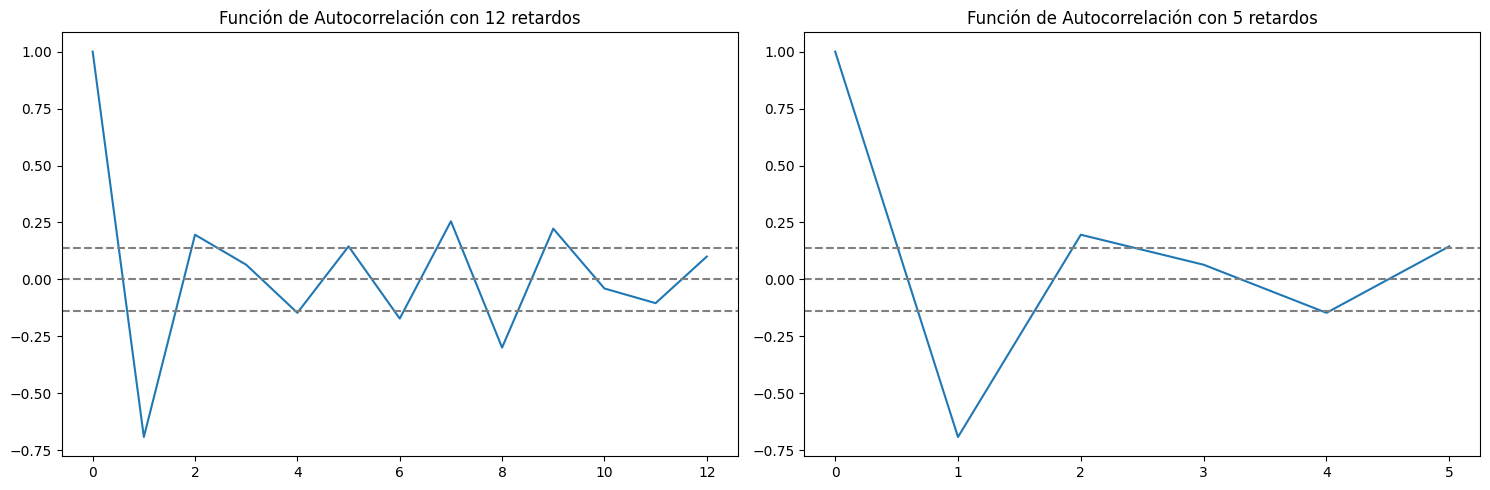

In [13]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_imp_D_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_imp_D_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

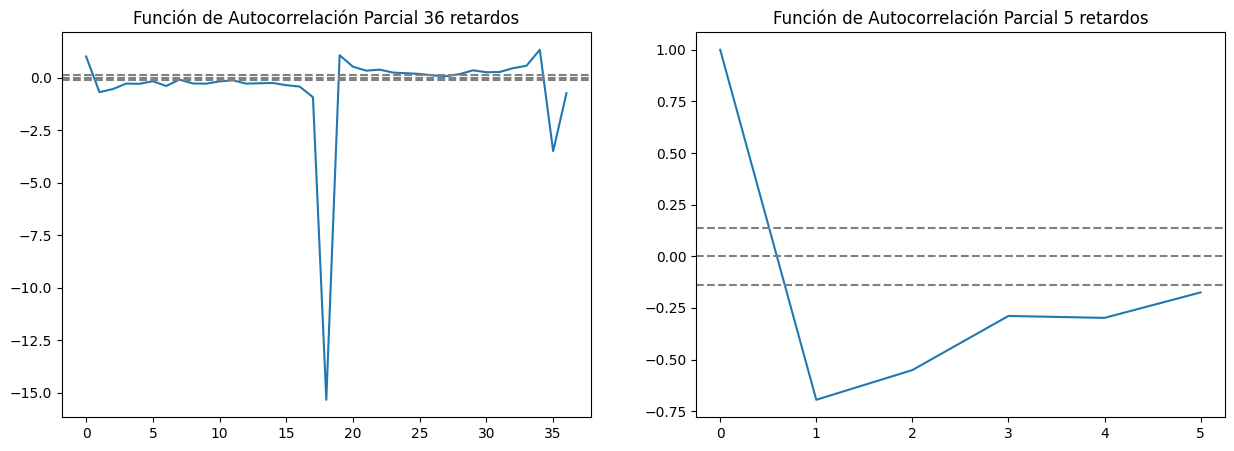

In [14]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_imp_D_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_imp_D_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### Estacionalidad

Veamos ahora si hay estacionalidad en la serie. Hagamos un gráfico de la función de autocorrelación usando 36 resagos:

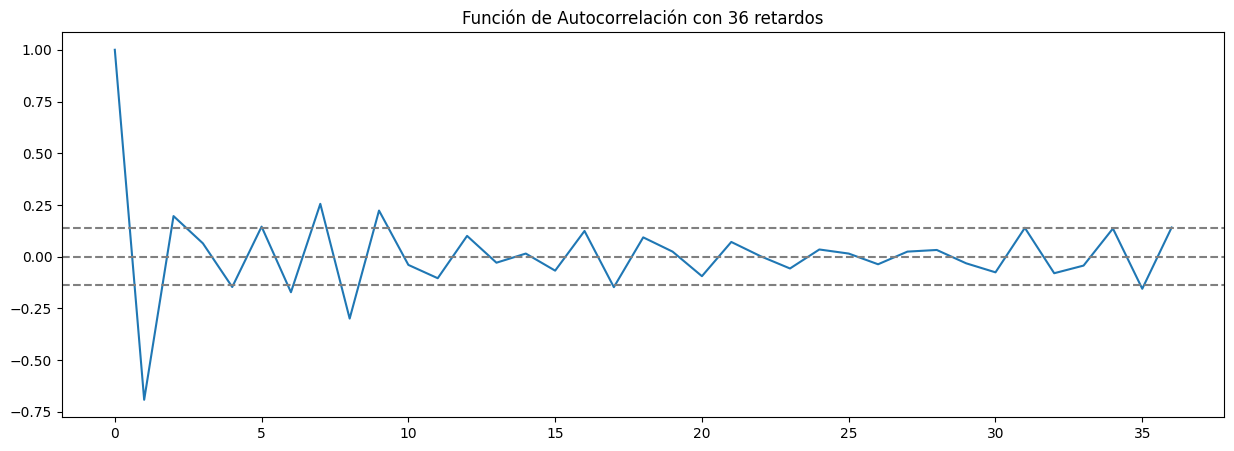

In [15]:
plt.plot(acf(ts_imp_D_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

La serie diferenciada no muestra autocorrelación significativa en los rezagos anuales, lo que sugiere que la estacionalidad fue eliminada o no es fuerte en la serie diferenciada.

In [16]:
ts_imp_D_log_D = ts_imp_D_log.diff(12)
ts_imp_D_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

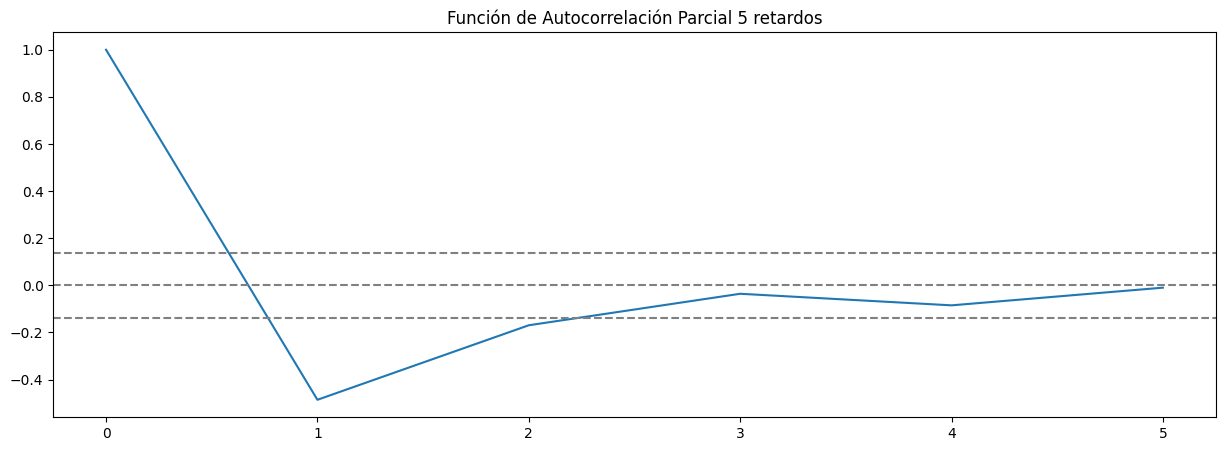

In [17]:
plt.plot(pacf(ts_imp_D_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

In [27]:
modelo111 = SARIMAX(ts_imp_D_log, order=(1,1,1), seasonal_order=(0,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
print(resultado_m111.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1681      0.076     -2.213      0.027      -0.317      -0.019
ma.L1         -1.0000     35.781     -0.028      0.978     -71.130      69.130
sigma2         0.1538      5.504      0.028      0.978     -10.633      10.941


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


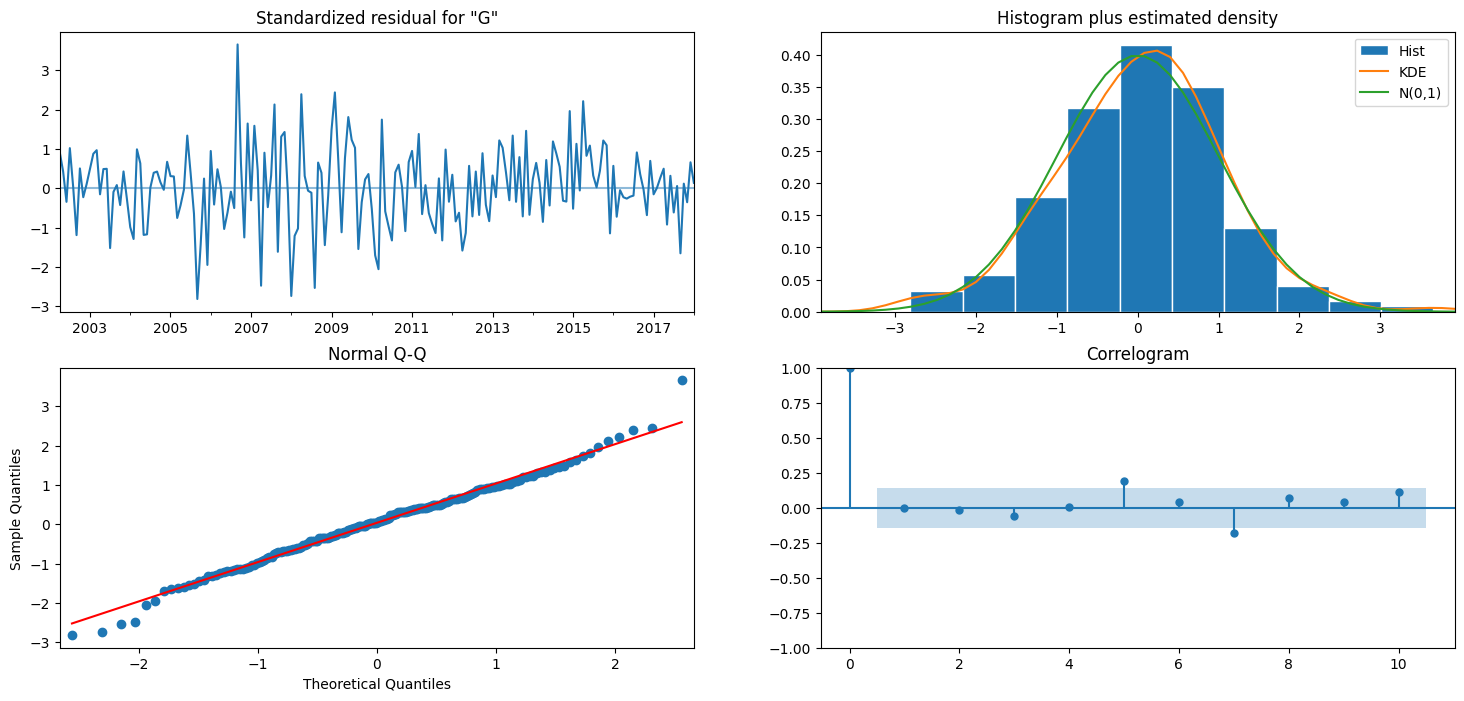

In [28]:
resultado_m111.plot_diagnostics(figsize=(18, 8))
plt.show()

In [29]:
modelo211 = SARIMAX(ts_imp_D_log, order=(2,1,1), seasonal_order=(0,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = modelo211.fit()
print(resultado_m211.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1689      0.076     -2.224      0.026      -0.318      -0.020
ar.L2         -0.0054      0.074     -0.072      0.942      -0.151       0.140
ma.L1         -1.0000     30.037     -0.033      0.973     -59.872      57.872
sigma2         0.1538      4.620      0.033      0.973      -8.901       9.209


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


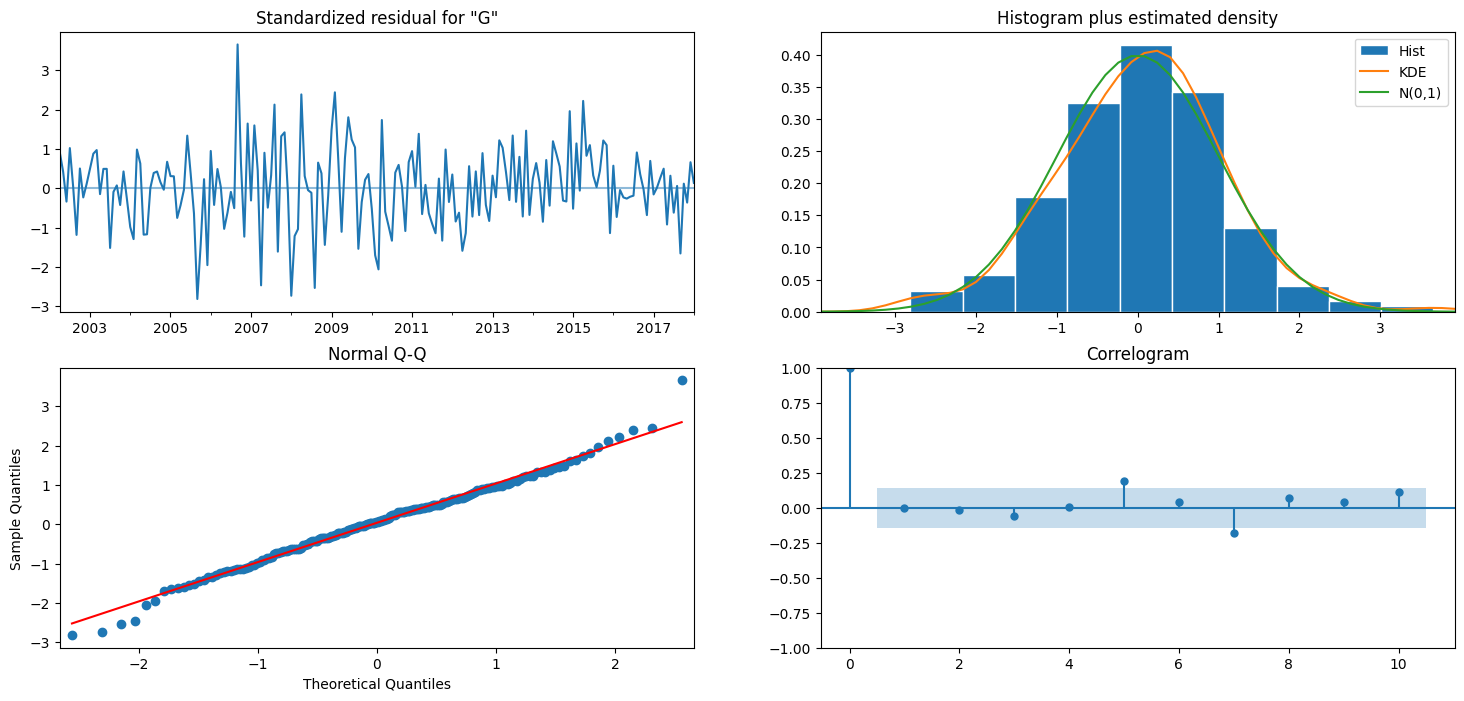

In [30]:
resultado_m211.plot_diagnostics(figsize=(18, 8))
plt.show()

En este otro modelo tampoco existen autocorrelaciones significativas y parecen estar distribuidos de forma normal

In [31]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111.aic)
print("Modelo 211=",resultado_m211.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111.bic)
print("Modelo 211=",resultado_m211.bic)

Resultados de AIC (Akaike information criterion)
Modelo 111= 193.7892538605193
Modelo 211= 195.78393519428383
Resultados de BIC (Bayesian information criterion)
Modelo 111= 203.53032607700075
Modelo 211= 208.77203148292577


El mejor modelo fue p=1, q=1, d=1

## Predicción con el mejor modelo

In [32]:
test_imp.index[0]

Timestamp('2021-09-01 00:00:00')

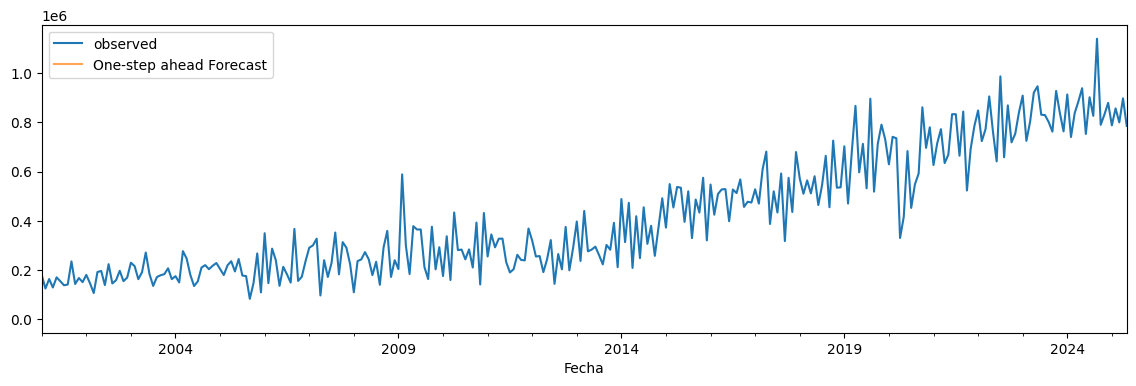

In [33]:
pred = resultado_m211.get_prediction(start=test_imp.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = imp['Gasolina regular'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred

In [34]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(imp) * 0.6)
val_size = int(len(imp) * 0.2)

train_imp = imp[0:train_size]
val_imp = imp[train_size:train_size + val_size]
test_imp = imp[train_size + val_size:len(imp)]

y_train = train_imp['Gasolina regular']
y_test = test_imp['Gasolina regular']

arima_model = ARIMA(y_train, order=(1, 1, 1))
arima_result = arima_model.fit()

y_pred_arima = arima_result.forecast(steps=len(y_test))

y_test_inv = y_test.values 
y_pred_arima_inv = y_pred_arima 

rmse_arima = np.sqrt(mean_squared_error(y_test_inv, y_pred_arima_inv))
mae_arima = mean_absolute_error(y_test_inv, y_pred_arima_inv)
print(f"ARIMA - RMSE (prueba): {rmse_arima:.2f}")
print(f"ARIMA - MAE (prueba): {mae_arima:.2f}")


ARIMA - RMSE (prueba): 346576.76
ARIMA - MAE (prueba): 326491.33


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [36]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(imp) * 0.7)
val_size = int(len(imp) * 0.15)

train_imp = imp[0:train_size]
val_imp = imp[train_size:train_size + val_size]
test_imp = imp[train_size + val_size:len(imp)]

y_train = train_imp['Gasolina regular']
y_test = test_imp['Gasolina regular']

arima_model = ARIMA(y_train, order=(2, 1, 1))
arima_result = arima_model.fit()

y_pred_arima = arima_result.forecast(steps=len(y_test))

y_test_inv = y_test.values
y_pred_arima_inv = y_pred_arima

rmse_arima = np.sqrt(mean_squared_error(y_test_inv, y_pred_arima_inv))
mae_arima = mean_absolute_error(y_test_inv, y_pred_arima_inv)

print(f"ARIMA - RMSE (prueba): {rmse_arima:.2f}")
print(f"ARIMA - MAE  (prueba): {mae_arima:.2f}")

ARIMA - RMSE (prueba): 306503.23
ARIMA - MAE  (prueba): 289829.83


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

# Aquí empieza el laboratorio 2

In [37]:
tf.random.set_seed(123)
imp = pd.read_csv("IMPORTACIONES.csv", parse_dates=['Fecha'], index_col='Fecha')
print('\n Parsed Data:')
print(imp.head())

imp_anual = imp.resample('Y').sum()

Gasolinaregular_anual = imp['Gasolina regular'].resample('Y').sum()

print(Gasolinaregular_anual)



 Parsed Data:
            Aceites lubricantes  Asfalto      Bunker  Ceras  \
Fecha                                                         
2001-01-01                  0.0  27748.99  214581.84    0.0   
2001-02-01                  0.0   7503.57  294609.00    0.0   
2001-03-01                  0.0  26304.32  315263.80    0.0   
2001-04-01                  0.0   7885.89  205653.00    0.0   
2001-05-01                  0.0   8443.16  278371.30    0.0   

            Combustible turbo jet     Diesel  Diesel ultra bajo azufre  \
Fecha                                                                    
2001-01-01                    0.0  566101.99                       0.0   
2001-02-01                    0.0  489525.80                       0.0   
2001-03-01                    0.0  575559.68                       0.0   
2001-04-01                    0.0  437745.42                       0.0   
2001-05-01                    0.0  552609.13                       0.0   

            Gas licuado 

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_42632\2893737678.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  imp_anual = imp.resample('Y').sum()
C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_42632\2893737678.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  Gasolinaregular_anual = imp['Gasolina regular'].resample('Y').sum()


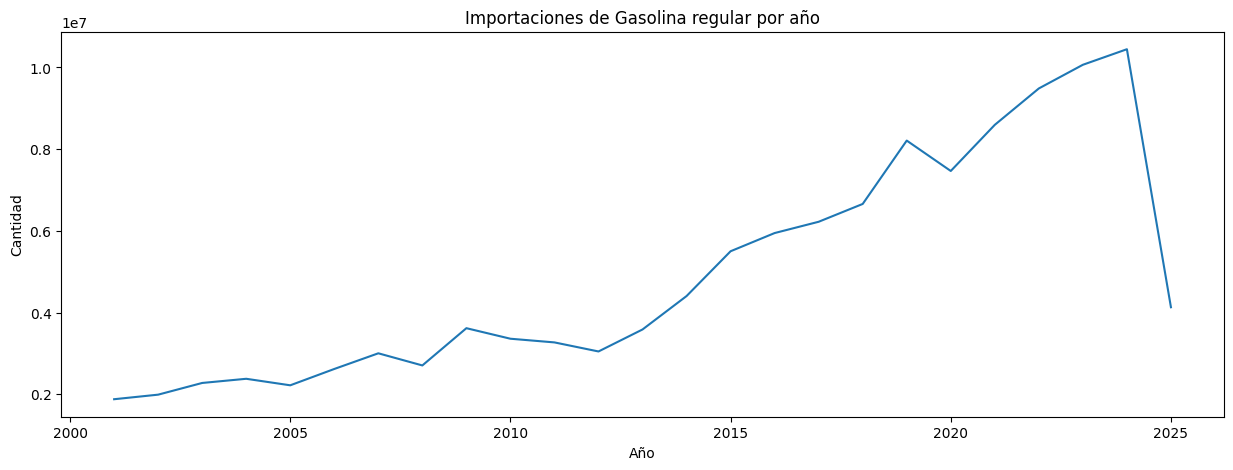

In [38]:
plt.plot(Gasolinaregular_anual.index.year, Gasolinaregular_anual.values)
plt.gca().set(title="Importaciones de Gasolina regular por año", xlabel="Año", ylabel="Cantidad")
plt.show()

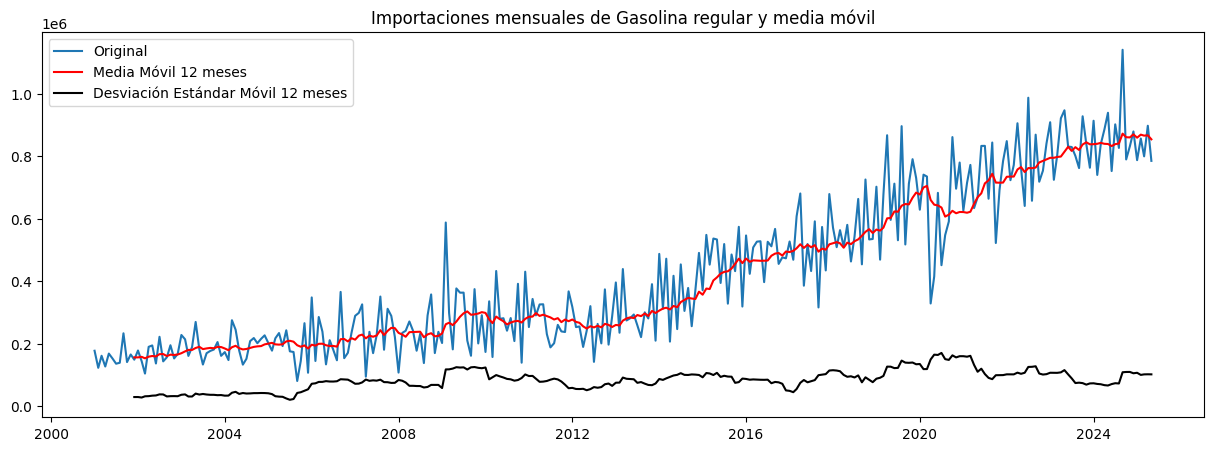

In [39]:
# Descomposición estacional
mediaMovil = imp['Gasolina regular'].rolling(window=12).mean()
deMovil = imp['Gasolina regular'].rolling(window=12).std()
plt.plot(imp['Gasolina regular'], label='Original')
plt.plot(mediaMovil, label='Media Móvil 12 meses', color='red')
plt.plot(deMovil, label='Desviación Estándar Móvil 12 meses', color='black')
plt.legend()
plt.title('Importaciones mensuales de Gasolina regular y media móvil')
plt.show()


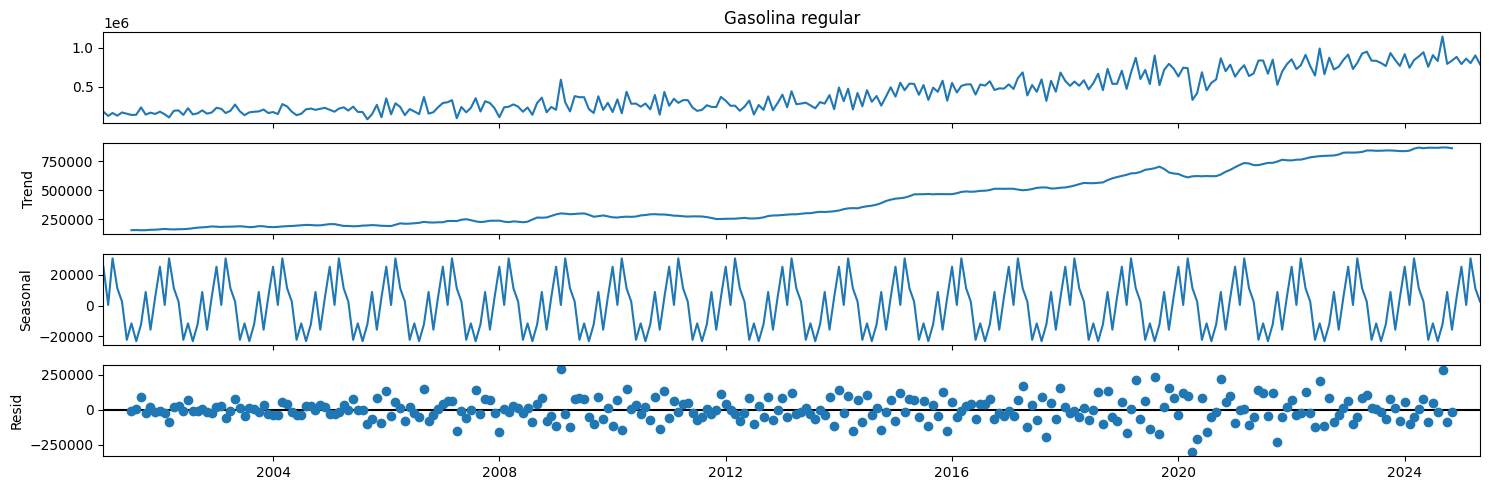

In [40]:
# Descomposición estacional sobre la serie mensual de Gasolina regular
descomposicion = seasonal_decompose(imp['Gasolina regular'], model='additive', period=12)
descomposicion.plot()
plt.show()


Tendencia (Trend): Se observa una tendencia creciente a lo largo de los años, con algunos periodos de estabilidad y repuntes, lo que indica un aumento sostenido en las importaciones de Diesel.

Estacionalidad (Seasonal): Ahora sí se detecta un patrón estacional claro, con oscilaciones regulares cada año. Esto significa que hay meses en los que las importaciones tienden a subir o bajar de forma recurrente, probablemente por factores económicos, climáticos o de demanda.

Residuales (Resid): Los residuales muestran variabilidad alrededor de cero, lo que indica que el modelo de descomposición logra capturar bien la tendencia y la estacionalidad, aunque aún hay cierta variabilidad no explicada (ruido).Tendencia (Trend): Se observa una tendencia creciente a lo largo de los años, con algunos periodos de estabilidad y repuntes, lo que indica un aumento sostenido en las importaciones de Gasolina regular.

Estacionalidad (Seasonal): Ahora sí se detecta un patrón estacional claro, con oscilaciones regulares cada año. Esto significa que hay meses en los que las importaciones tienden a subir o bajar de forma recurrente, probablemente por factores económicos, climáticos o de demanda.

Residuales (Resid): Los residuales muestran variabilidad alrededor de cero, lo que indica que el modelo de descomposición logra capturar bien la tendencia y la estacionalidad, aunque aún hay cierta variabilidad no explicada (ruido).

In [41]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = imp['Gasolina regular'].diff()
ts_imp_D_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.021058e+01
p-value                      5.652315e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.840000e+02
Critical Value (1%)         -3.453587e+00
Critical Value (5%)         -2.871771e+00
Critical Value (10%)        -2.572222e+00
dtype: float64


Con una diferenciacion la serie es estacionaria en la media.


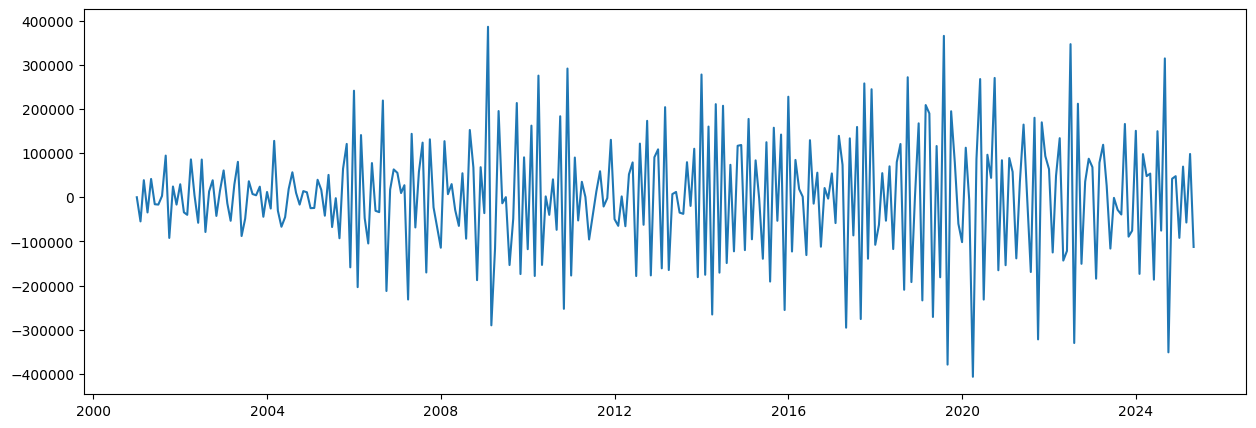

In [42]:
plt.plot(ts_imp_D_diff)

In [43]:
scaler = StandardScaler()
ts_imp_D_scaled = scaler.fit_transform(ts_imp_D_diff.values.reshape(-1, 1))
ts_imp_D_scaled[1:7]

array([[-0.41778953],
       [ 0.26904312],
       [-0.26850357],
       [ 0.28952212],
       [-0.13185581],
       [-0.13751758]])

In [44]:
val_prueba = round(0.15*len(ts_imp_D_scaled))
val_prueba

44

In [45]:
entrenamiento = round(0.7*len(ts_imp_D_scaled))
val_prueba = round(0.15*len(ts_imp_D_scaled))
test = ts_imp_D_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_imp_D_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_imp_D_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

45

In [46]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [47]:
print(train[0:7])
print(x_train[0:7])
print(y_train[0:7])

[[ 0.        ]
 [-0.01527806]
 [-0.41778953]
 [ 0.26904312]
 [-0.26850357]
 [ 0.28952212]
 [-0.13185581]]
[[ 0.        ]
 [-0.01527806]
 [-0.41778953]
 [ 0.26904312]
 [-0.26850357]
 [ 0.28952212]
 [-0.13185581]]
[-0.01527806 -0.41778953  0.26904312 -0.26850357  0.28952212 -0.13185581
 -0.13751758]


Creando el modelo

In [48]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

44

In [49]:
x_train

array([[[ 0.00000000e+00]],

       [[-1.52780628e-02]],

       [[-4.17789528e-01]],

       [[ 2.69043118e-01]],

       [[-2.68503572e-01]],

       [[ 2.89522115e-01]],

       [[-1.31855813e-01]],

       [[-1.37517578e-01]],

       [[ 7.29904086e-03]],

       [[ 6.78975424e-01]],

       [[-6.93440446e-01]],

       [[ 1.63598838e-01]],

       [[-1.37693058e-01]],

       [[ 2.00985221e-01]],

       [[-2.66669975e-01]],

       [[-3.08164720e-01]],

       [[ 6.15548279e-01]],

       [[ 1.77936967e-02]],

       [[-4.40755811e-01]],

       [[ 6.13279037e-01]],

       [[-5.94171927e-01]],

       [[ 8.16441147e-02]],

       [[ 2.68008277e-01]],

       [[-3.26334931e-01]],

       [[ 9.08423658e-02]],

       [[ 4.31506894e-01]],

       [[-1.16742996e-01]],

       [[-4.07279187e-01]],

       [[ 1.95087908e-01]],

       [[ 5.74985333e-01]],

       [[-6.61290640e-01]],

       [[-3.73058006e-01]],

       [[ 2.51555683e-01]],

       [[ 3.85786617e-02]],

       [[ 1.74

### Creamos el modelo.   
#### Tensor Flow
Vamos a utilizar solo una capa LSTM 

In [50]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

#Tensor Flow 2
#modelo1 = Sequential()
#modelo1.add(LSTM(lote,batch_input_shape=(lote,paso,caracteristicas),stateful=True))
#modelo1.add(Dense(1))
#modelo1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
#early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

In [52]:
modelo1

<Functional name=functional, built=True>

In [53]:
epocas = 150
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3570 - root_mean_squared_error: 0.5765 - val_loss: 1.3203 - val_root_mean_squared_error: 1.1490
Epoch 2/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3246 - root_mean_squared_error: 0.5537 - val_loss: 1.3215 - val_root_mean_squared_error: 1.1495
Epoch 3/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3262 - root_mean_squared_error: 0.5549 - val_loss: 1.3159 - val_root_mean_squared_error: 1.1471
Epoch 4/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3255 - root_mean_squared_error: 0.5542 - val_loss: 1.3131 - val_root_mean_squared_error: 1.1459
Epoch 5/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3247 - root_mean_squared_error: 0.5535 - val_loss: 1.3113 - val_root_mean_squared_error: 1.1451
Epoch 6/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3240 - root_mean_squared_error: 0.5529 - val_loss: 1.3098 - val_root_mean_squared_error: 1.1445
Epoch 7/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

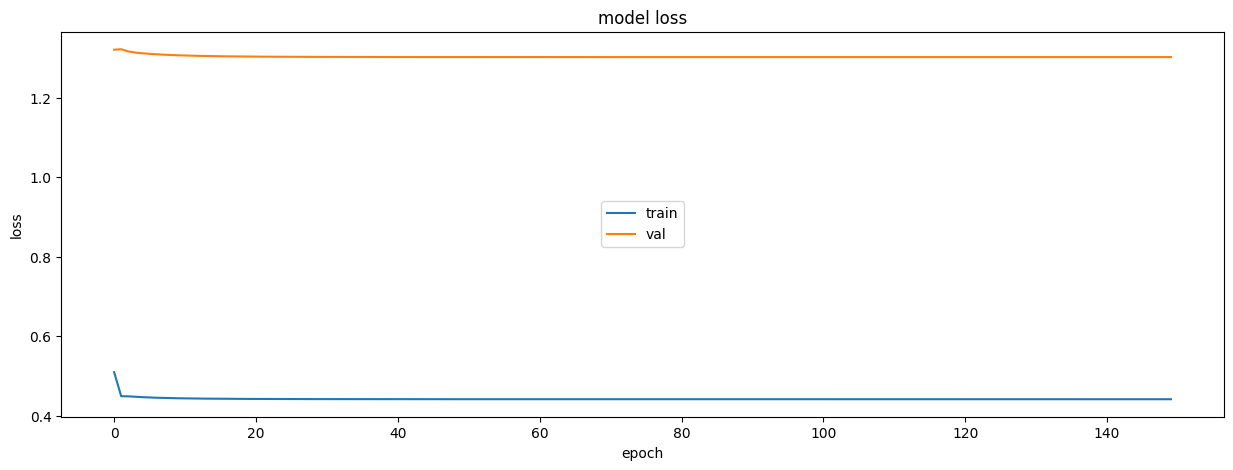

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

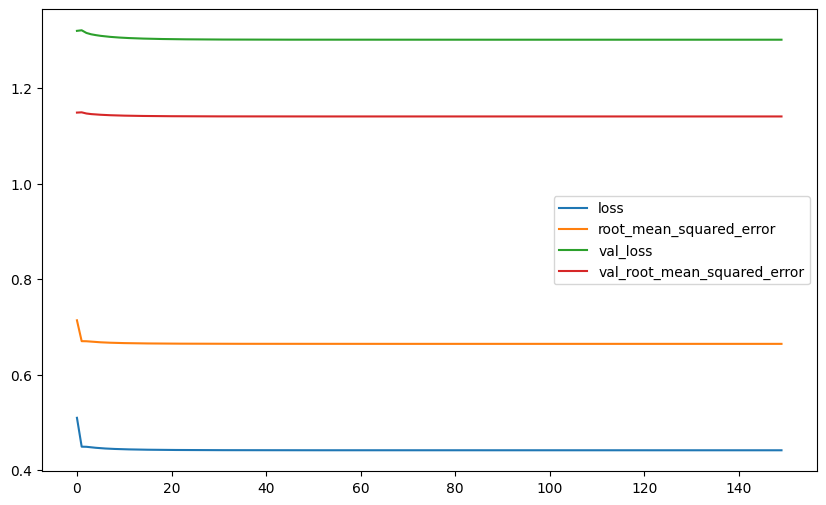

In [55]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [56]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3520 - root_mean_squared_error: 0.5860  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3684 - root_mean_squared_error: 1.1691
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8545 - root_mean_squared_error: 0.9242


[0.8277744054794312, 0.909821093082428]

In [57]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = imp['Gasolina regular'].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = imp['Gasolina regular'].values , n=entrenamiento+val_prueba)


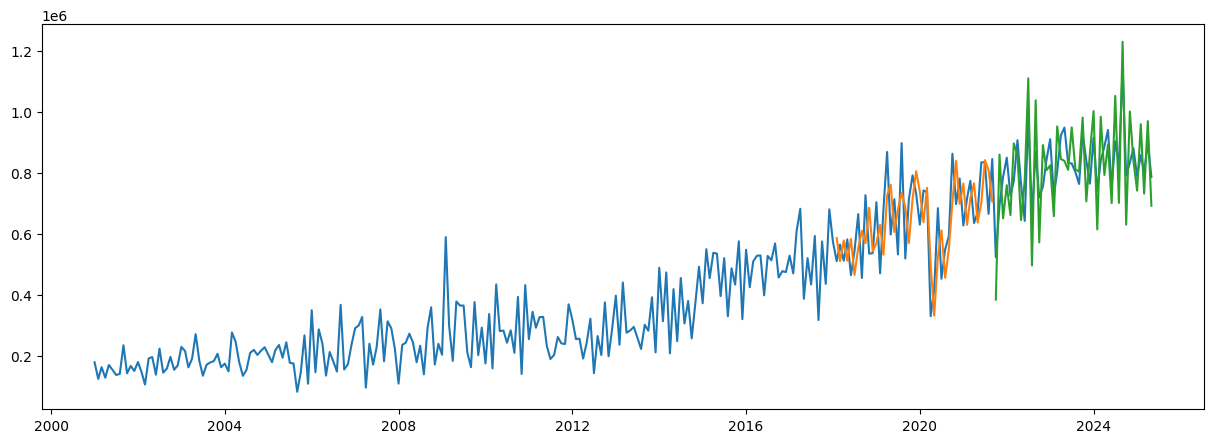

In [58]:
df_val = pd.DataFrame(prediccion_val,index=imp['Gasolina regular'][(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=imp['Gasolina regular'][entrenamiento+len(df_val):len(imp['Gasolina regular'])].index)


plt.plot(imp['Gasolina regular'])
plt.plot(df_val)
plt.plot(df_test)

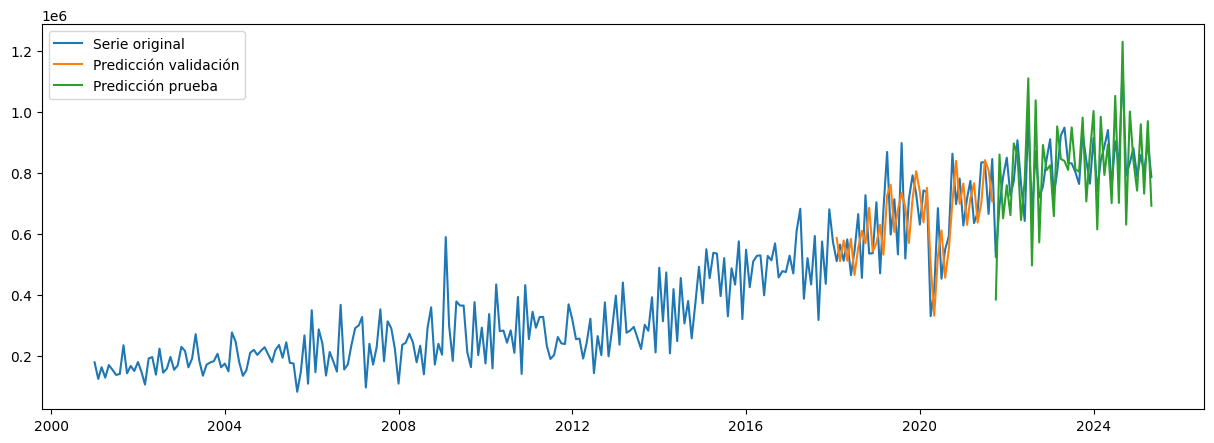

In [59]:
plt.plot(imp['Gasolina regular'], label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.show()

## Pytorch

Se define la clase que hereda de los modelos nn de pytorch para este modelo en específico

In [60]:
class LSTMMiModelo(nn.Module):
    def __init__(self,input_size=1,hidden_size=20, num_layers = 1,output_size = 1 ):
        super().__init__()
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  
        self.hidden_size = hidden_size

    def forward(self,x):
        # x shape: (batch, seq_len, input_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [61]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 12 #Por el ciclo estacional, una ventana de un año

# Después, rehace tus ventanas:
x_train, y_train = create_sequences(train, SEQ_LENGTH)
x_val, y_val     = create_sequences(validation, SEQ_LENGTH)
x_test, y_test   = create_sequences(test, SEQ_LENGTH)

In [62]:
model = LSTMMiModelo()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Preparación de los datos
x_train_tensor = torch.from_numpy(x_train).float()        
y_train_tensor = torch.from_numpy(y_train).float()
x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Entrenamiento
En pytorch hay que hacer el entrenamiento "a mano" para tener el control del todo

In [63]:
train_losses = []
val_losses = []
model.train()
running_train_loss = 0.0
for epoch in range(epocas):
    running_train_loss = 0.0  # Acumula la pérdida de la época
    for xb, yb in train_loader:  # Recorre cada batch
        outputs = model(xb)
        loss = loss_fn(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)
    
    # Calcula y muestra la pérdida promedio en el entrenamiento de la época
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) 

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = loss_fn(outputs, yb)
            running_val_loss += loss.item() * xb.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Loss promedio: {epoch_train_loss:.5f}")

Epoch 1, Loss promedio: 0.80312
Epoch 10, Loss promedio: 0.38229
Epoch 20, Loss promedio: 0.36542
Epoch 30, Loss promedio: 0.34648
Epoch 40, Loss promedio: 0.33755
Epoch 50, Loss promedio: 0.31827
Epoch 60, Loss promedio: 0.33348
Epoch 70, Loss promedio: 0.29526
Epoch 80, Loss promedio: 0.30818
Epoch 90, Loss promedio: 0.23031
Epoch 100, Loss promedio: 0.19388
Epoch 110, Loss promedio: 0.16347
Epoch 120, Loss promedio: 0.12925
Epoch 130, Loss promedio: 0.12973
Epoch 140, Loss promedio: 0.23452
Epoch 150, Loss promedio: 0.13473


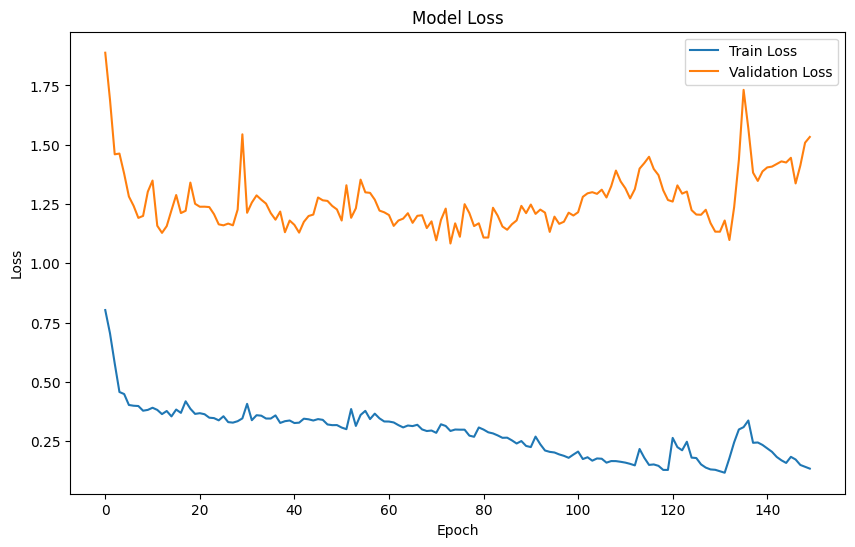

In [64]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
model.eval()
with torch.no_grad():
    # Forma: (num_ejemplos, ventana, 1)
    y_pred_test = model(x_test_tensor)
    y_pred_test = y_pred_test.numpy()  # Convierte a numpy para graficar

In [66]:
#Desnormalizar
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

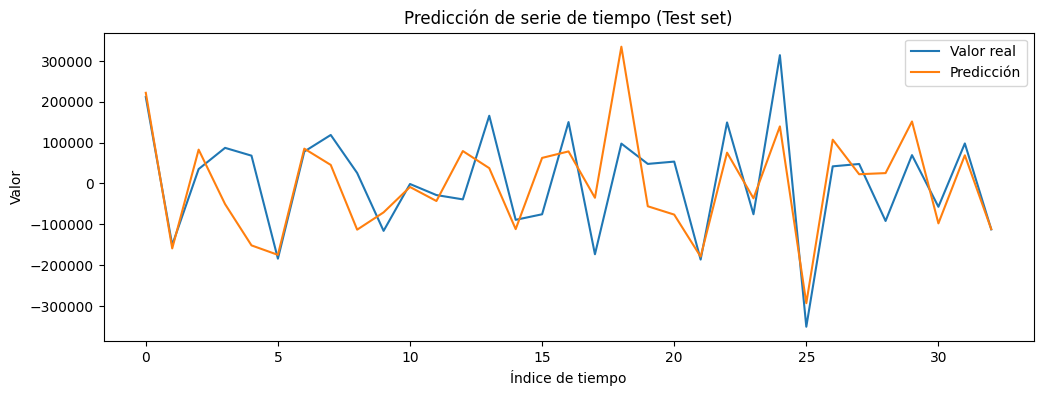

In [67]:
# Graficar
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label='Valor real')
plt.plot(y_pred_test_inv, label='Predicción')
plt.title('Predicción de serie de tiempo (Test set)')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae_lstm = mean_absolute_error(y_test_inv, y_pred_test_inv)

print(f"LSTM - RMSE (test): {rmse_lstm:.2f}")
print(f"LSTM - MAE  (test): {mae_lstm:.2f}")

LSTM - RMSE (test): 99087.99
LSTM - MAE  (test): 76406.44


# Comparativa entre modelos

In [69]:
# Comparación de métricas entre ARIMA y LSTM

print(f"ARIMA - RMSE (prueba): {rmse_arima:.2f}")
print(f"ARIMA - MAE  (prueba): {mae_arima:.2f}")
print(f"LSTM - RMSE (prueba): {rmse_lstm:.2f}")
print(f"LSTM - MAE  (prueba): {mae_lstm:.2f}")

print("\nComparación de modelos:")
if rmse_arima < rmse_lstm:
    print("ARIMA tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.")
else:
    print("LSTM tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.")

if mae_arima < mae_lstm:
    print("ARIMA tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.")
else:
    print("LSTM tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.")

ARIMA - RMSE (prueba): 306503.23
ARIMA - MAE  (prueba): 289829.83
LSTM - RMSE (prueba): 99087.99
LSTM - MAE  (prueba): 76406.44

Comparación de modelos:
LSTM tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.
LSTM tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.
